# ZNE with AER Estimator

In [29]:

from qiskit.providers.fake_provider import FakeNairobi, FakeGuadalupeV2, FakeGuadalupe
import numpy as np 
from zne import zne, ZNEStrategy
from zne.noise_amplification import LocalFoldingAmplifier
from zne.extrapolation import PolynomialExtrapolator

In [30]:
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import RealAmplitudes

## Build our input circuit and observable
circuit = random_circuit(2, 4, seed=1).decompose(reps=1)
# circuit = RealAmplitudes(num_qubits=2)
observable = SparsePauliOp("ZZ")

In [31]:
circuit.decompose().draw()

global phase: 5.3035
     ┌───┐┌─────────────┐                          ┌─────────┐  ┌───┐»
q_0: ┤ X ├┤ U(0,0,-π/4) ├──■──────────────────■────┤ U2(0,π) ├──┤ X ├»
     └─┬─┘└─────────────┘┌─┴─┐┌────────────┐┌─┴─┐┌─┴─────────┴─┐└─┬─┘»
q_1: ──■─────────────────┤ X ├┤ U(0,0,π/4) ├┤ X ├┤ U(0,0,-π/4) ├──■──»
                         └───┘└────────────┘└───┘└─────────────┘     »
«     ┌────────────┐┌───┐  ┌─────────┐   ┌─────────────┐
«q_0: ┤ U1(1.9593) ├┤ X ├──┤ U2(0,π) ├───┤ U3(0,0,π/4) ├
«     └────────────┘└─┬─┘┌─┴─────────┴──┐└─────────────┘
«q_1: ────────────────■──┤ U(π,π/2,π/2) ├───────────────
«                        └──────────────┘

In [32]:
num_parameters = circuit.num_parameters
parameters = np.random.rand(num_parameters)

# Exact Results

In [33]:
from qiskit.primitives import Estimator
estimator = Estimator()

job = estimator.run(
    circuit,
    observable,
    # parameters,
    shots = None
)
exact_values = job.result().values
print(exact_values)

[0.37879921]


# Noise results

In [34]:
from qiskit.primitives import Estimator
estimator_noise = Estimator(options={'shots':1000})

job = estimator_noise.run(
    circuit,
    observable,
    # parameters,
)
noisy_values = job.result().values
print(noisy_values)

[0.43090291]


# Aer Results

In [35]:
from qiskit_aer.primitives import Estimator as AerEstimator  
from qiskit_aer.noise import NoiseModel 
seed = 170
device = FakeGuadalupe()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)
aer_estimator = AerEstimator(
    backend_options={
        "method": "density_matrix",
        "coupling_map": coupling_map,
        "noise_model": noise_model,
    },
    run_options={"seed": seed, "shots": 10000},
    transpile_options={"seed_transpiler": seed},
)

In [36]:
## Run experiment
job = aer_estimator.run(
    circuit, 
    observable,
    # parameters
    )  # !!!
result = job.result()

## Display results
# display(circuit.draw("mpl"))
# print(f"  > Observable: {observable.paulis}")
# print(f"  > Expectation value: {result.values[0]}")
# print(f"  > Metadata: {result.metadata[0]}")

1
1


# ZNE Results

In [37]:
from qiskit_aer.primitives import Estimator as AerEstimator
from qiskit_aer.noise import NoiseModel
seed = 170
device = FakeGuadalupe()
coupling_map = device.configuration().coupling_map
noise_model = NoiseModel.from_backend(device)

In [50]:
## Build ZNEEstimator
ZNEEstimator = zne(AerEstimator)
zne_estimator = ZNEEstimator(
    options=
    {
        'shots':10000,
        'backend_options':{
            "method": "density_matrix",
            "coupling_map": coupling_map,
            "noise_model": noise_model,
        },
        'run_options' : {"seed": seed, "shots": 10000},
        'transpile_options':{"seed_transpiler": seed}
    }
)

TypeError: __init__() got an unexpected keyword argument 'options'

In [47]:
zne_strategy = ZNEStrategy(
    noise_factors=range(1, 9),
    noise_amplifier=LocalFoldingAmplifier(gates_to_fold=2),
    extrapolator=PolynomialExtrapolator(degree=3),
)

In [48]:
## Run experiment
job = zne_estimator.run(
    circuit, 
    observable,
    # parameters, 
    zne_strategy=zne_strategy)  # !!!
result = job.result()

## Display results
# display(circuit.draw("mpl"))
# print(f"  > Observable: {observable.paulis}")
# print(f"  > Expectation value: {result.values[0]}")
# print(f"  > Metadata: {result.metadata[0]}")

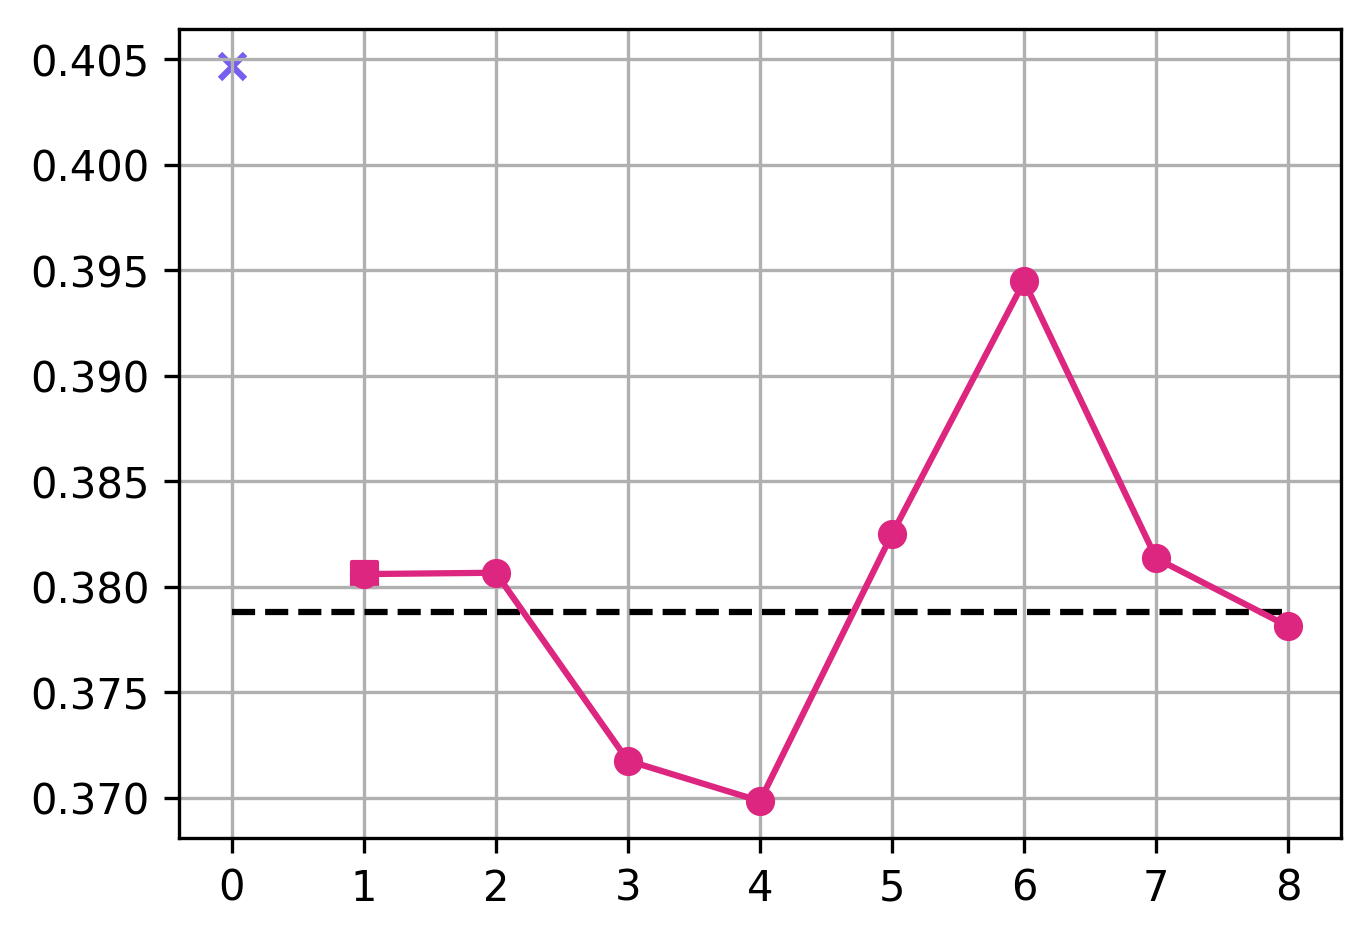

In [49]:
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams["figure.dpi"] = 300
# plt.rcParams.update({"text.usetex": True, "font.family": "Computer Modern Roman"})

############################  DATA  ############################

exact = exact_values[0]  # From simulation above
mitigated = result.values[0]
noise_factors = result.metadata[0]["zne"]["noise_amplification"]["noise_factors"]
noisy_values = result.metadata[0]["zne"]["noise_amplification"]["values"]

############################  PLOT  ############################
plt.rcParams["figure.figsize"] = (5,3.5)
plt.grid(which='major',axis='both')

plt.plot([0, noise_factors[-1]], [exact, exact], "--", label="Exact", color="#000000")
plt.scatter(0, mitigated, label="Mitigated", marker="x", color="#785ef0")
if noise_factors[0] == 1:
    plt.scatter(
        noise_factors[0], noisy_values[0], 
        label="Unmitigated", marker="s", color="#dc267f",
    )
plt.plot(
    noise_factors, noisy_values, 
    label="Amplified", marker="o", color="#dc267f",
)

plt.show()